In [1]:
#2D simulation of a wave propagating through inhomogeneous medium
import cmath
import numpy as np
import matplotlib.pyplot as plt
from fun_propagate import fun_propagate
from scan import scan
from grating1D import grating1D
from input_wavefront import input_wavefront

In [14]:
#user parameters
n = 8
m = 2

N=np.array([int(512/n), int(1024/m)]) # size of grid z,x
u=np.array([.2*n, .1*m]) #units z, x in lambda
NA=0.5 #NA of lens
RI=np.array([1.33, 1.4]) #refractive indices of turbid sample (we assume a binary RI-distribution for simplicity)

In [15]:
#creating real-space grid
x=np.arange(-N[1]/2,N[1]/2)*u[1]  #simulation window shows +/- 5 wavelengths in x
z=np.arange(0,N[0])*u[0]  #simulation window shows ~5 wavelengths in z
[X,Z]=np.meshgrid(x,z)

#creating k-space grid
uk=2*np.pi/u/N   #increment in frequency-space is 1/(size of grid in x-space); increment in k-space is 2*pi/(size of grid in x-space)
kx=np.arange(-N[1]/2,N[1]/2)*uk[1] 
kz=np.arange(0,N[0])*uk[0]
[Kx,Kz]=np.meshgrid(kx,kz)

[10.24 10.24]


Text(0.5,1,'RI distribution of sample')

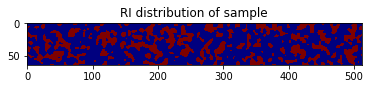

In [29]:
#defining random sample

tmp=np.random.random(N) #array of random numbers with dimensions of N

#low-pass filtering of random sample (performed in k-space)

F_tmp=np.fft.fft2(tmp)  #fourier transform random array
sigma=N*u/10  # 10% of simulation region in units of wavelength
F_filter=np.exp(-X**2/sigma[1]**2-(Z-N[0]*u[0]/2)**2/sigma[0]**2) #Gaussian LP filter function
tmp2=np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(F_filter*F_tmp))) #apply filter, undo shift to center spectrum on zero in k space
                                                                    #2d fft back to lambda space and shift center back to zero
sample=np.fft.ifftshift((tmp2/np.max(tmp2)>0.1)*(RI[1]-RI[0])+RI[0], 1) #undo shift to center on zero for X axis, and threshold normalized values to >0.1
plt.imshow(np.real(sample),cmap='jet')   #Plot real part of filtered random refractive indices
plt.title('RI distribution of sample')


Text(0.5,0,'x')

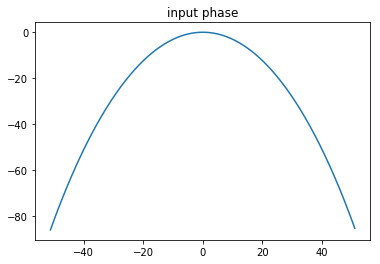

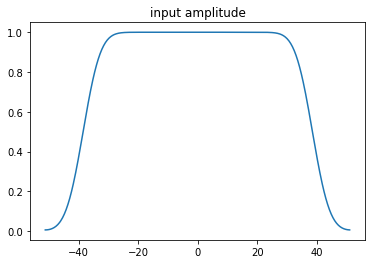

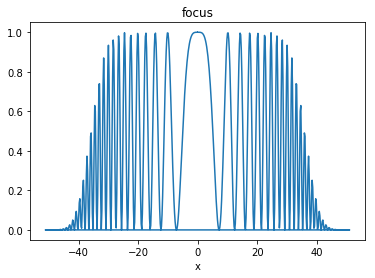

In [17]:
# E_in, phase, amp = input_wavefront(NA, N, u)

NA_geo=NA/1.33 #geometric NA of our objective lens
# phase
R=N[0]*u[0] #radius of curvature; define it such that focus lies at last layer
phase = 2*np.pi*(np.sqrt(0j+R**2-x**2)-R)  # spherical phase
# amplitude
amp0=np.abs(x)<R*NA_geo #wave amplitude is 1 for x less than R*NA_geo, didn't know this function of the < operator
sigma_amp=1 #we filter the amplitude a bit to make the edges less sharp
amp_filter=np.exp(-x**2/sigma_amp**2)
F_amp0=np.real(np.fft.fftshift(np.fft.fft(np.fft.ifftshift(amp0))))
amp=np.real(np.fft.fftshift(np.fft.ifft(np.fft.ifftshift(F_amp0*amp_filter))))
#full wavefront
E=np.zeros(N,dtype='complex') #initializing field 
E_in=np.fft.ifftshift(amp*np.exp(1j*phase))  #already apply ifftshift (loop later is faster)

plt.figure(1)
plt.plot(x,np.real(phase))
plt.title('input phase')

plt.figure(2)
plt.plot(x,amp)
plt.title('input amplitude')

plt.figure(3)
plt.plot(np.fft.fftshift(x),(np.real(E_in)**2))
plt.title('focus')
plt.xlabel('x')

Text(0.5,0,'x')

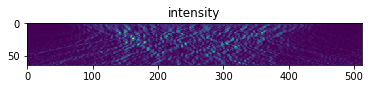

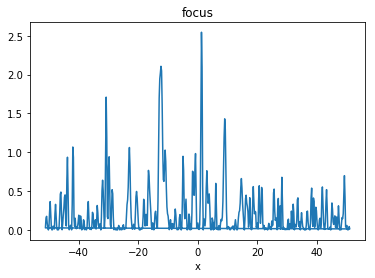

In [18]:
#now we propagate through the turbid sample 

E=fun_propagate(u, E_in,sample)   #execute propagation 
    
plt.figure(1)
plt.imshow(np.fft.fftshift(abs(E)**2,1))
plt.title("intensity")

plt.figure(2)
plt.plot(np.fft.fftshift(x),(np.real(E[-1,:])**2))
plt.title('focus')
plt.xlabel('x')

Text(0.5,0,'x')

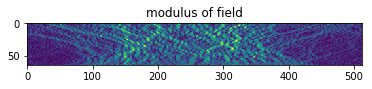

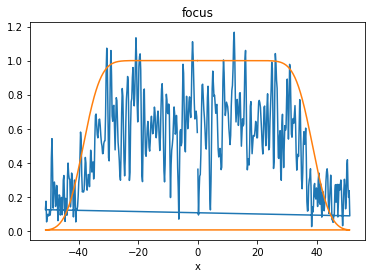

In [19]:
#test: propagating the scrambled focus backwards through the aberrating sample
#we should see that the aberration-free wavefront is (almost) restored

E2=fun_propagate(u,np.conj(E[-1,:]),np.flip(sample,0)) 
plt.figure(1)
plt.imshow(np.fft.fftshift(abs(E2)**1,1))
plt.title("modulus of field")

plt.figure(2)
plt.plot(np.fft.fftshift(x),(np.abs(E2[-1,:])))
plt.plot(np.fft.fftshift(x),(np.abs(E_in)))
plt.title('focus')
plt.xlabel('x')

Text(0.5,1,'intensity')

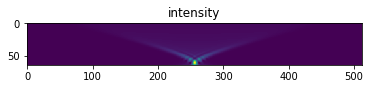

In [20]:
#now we propagate through a clear sample in order to get an undistored focus
#RI_avg=np.mean(sample)
sample_clear=np.ones(sample.shape)*1.33
E_gs=fun_propagate(u,E_in,sample_clear)  #gs for "guidestar"

plt.figure(1)
plt.imshow(np.fft.fftshift(abs(E_gs)**2,1))
plt.title("intensity")


Text(0.5,0,'x')

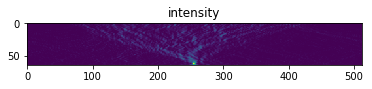

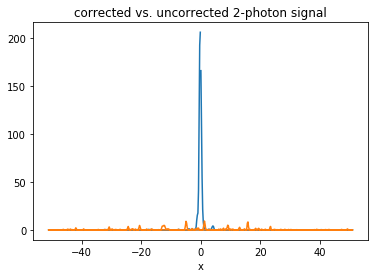

In [21]:
#now we propagate the "guidestar" through the turbid sample

E3=fun_propagate(u,np.conj(E_gs[-1,:]),np.flip(sample,0))
E_corr=np.conj(E3[-1,:]) #this is our correction field for the central imaging point

E_test=fun_propagate(u,abs(E_in)*E_corr/np.abs(E_corr),sample) #we can only correct the phase
#E_test=fun_propagate(u, E_corr,sample)
E_test2=fun_propagate(u, E_in,sample)

plt.figure(1)
plt.imshow(np.fft.fftshift(abs(E_test)**2,1))
plt.title("intensity")

plt.figure(2)
plt.plot(np.fft.fftshift(x),np.abs(E_test[-1,:])**4)
plt.plot(np.fft.fftshift(x),np.abs(E_test2[-1,:])**4)
plt.title('corrected vs. uncorrected 2-photon signal')
plt.xlabel('x')

In [22]:
#focusing through a clear sample
image=scan(u,E_in, sample_clear, 50, 4, 200)
image_corr=scan(u,abs(E_in)*E_corr/abs(E_corr), sample_clear, 50, 4, 200)

Text(0.5,1,'2-photon image')

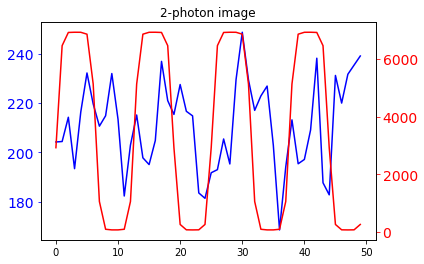

In [23]:
fig, ax1 = plt.subplots()
ax1.plot(image_corr, 'b')
ax1.tick_params('y', colors='b', labelsize = 14)
ax2 = ax1.twinx()
ax2.plot(image, 'r')
ax2.tick_params('y', colors='r', labelsize = 14)
plt.title('2-photon image')

In [24]:
#focusing through the scattering sample
image=scan(u,E_in, sample, 50, 4, 200)
image_corr=scan(u,abs(E_in)*E_corr/abs(E_corr), sample, 50, 4, 200)

Text(0.5,1,'2-photon image')

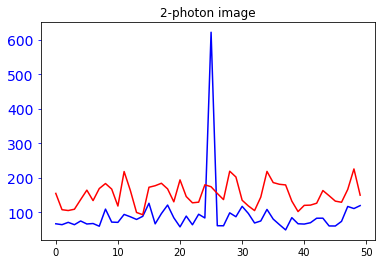

In [25]:
fig, ax1 = plt.subplots()
ax1.plot(image_corr, 'b')
ax1.tick_params('y', colors='b', labelsize = 14)
# ax2 = ax1.twinx()
ax1.plot(image, 'r')
ax2.tick_params('y', colors='r', labelsize = 14)
plt.title('2-photon image')